In [1]:
import os
import cv2
import tensorflow as tf
import segmentation_models as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataset import modify_mask
import requests, io
import numpy as np
from PIL import Image

2023-06-03 15:48:23.404590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 15:48:24.443367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


2023-06-03 15:48:27.310886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 15:48:27.421935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 15:48:27.422023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 15:48:27.425037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 15:48:27.425152: I tensorflow/compile

/tmp/ipykernel_6756/745268960.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


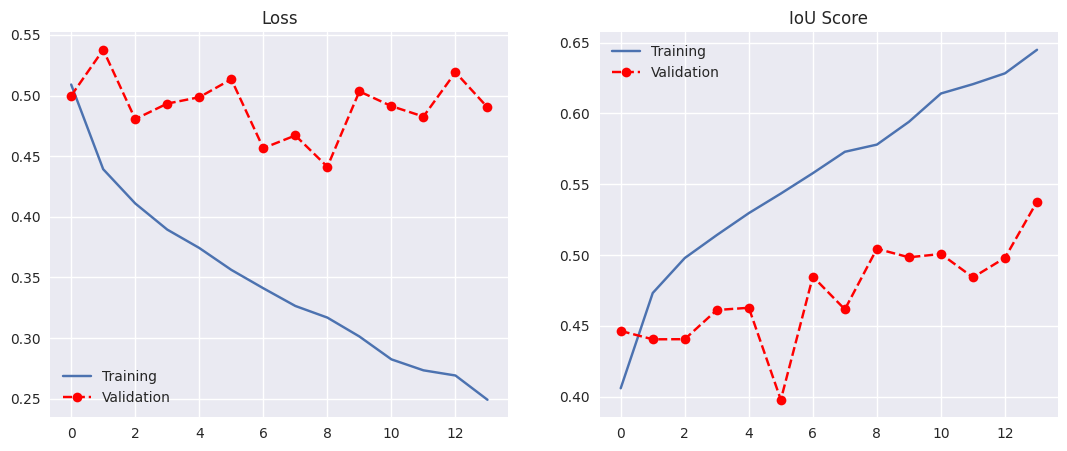

In [2]:
# Recreate the exact same model, including its weights and the optimizer
basedir = os.getcwd()
model_path = os.path.join(basedir, 'result', 'tf_pruning.h5')
history_path = os.path.join(basedir, 'result', 'history.csv')
unet_model = tf.keras.models.load_model(model_path, custom_objects={"iou_score": sm.metrics.iou_score})

# Show the model architecture
#unet_model.summary()
df = pd.read_csv(history_path)
plt.style.use('seaborn')
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(df['loss'], label = 'Training')
plt.plot(df['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(df['iou_score'], label = 'Training')
plt.plot(df['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()

2023-06-03 15:48:32.561226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-03 15:48:34.142572: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


(-0.5, 63.5, 63.5, -0.5)

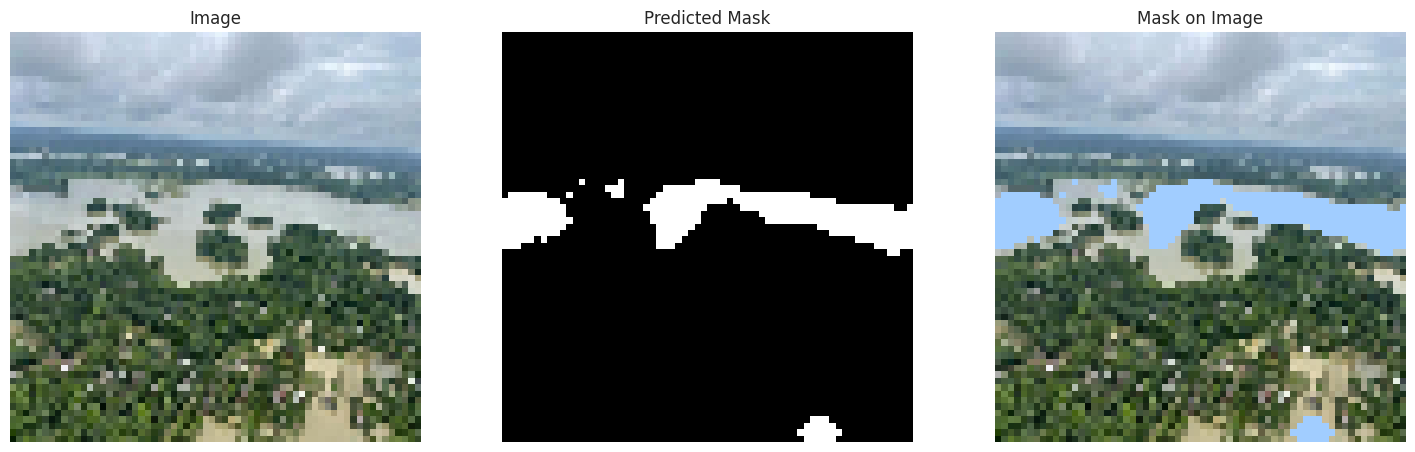

In [3]:
color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'

IMG_SIZE = (64, 64)

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = cv2.resize(img, IMG_SIZE)
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(unet_model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))